In [3]:
!unzip /content/drive/MyDrive/Potato_Disease_Detection.zip

Archive:  /content/drive/MyDrive/Potato_Disease_Detection.zip
   creating: Potato_Disease_Detection/Potato___Early_blight/
  inflating: Potato_Disease_Detection/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: Potato_Disease_Detection/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: Potato_Disease_Detection/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: Potato_Disease_Detection/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: Potato_Disease_Detection/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: Potato_Disease_Detection/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: Potato_Disease_Detection/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: Potato_Disease_De

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set all the Constants

In [5]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS= 50

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Disease_Detection",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

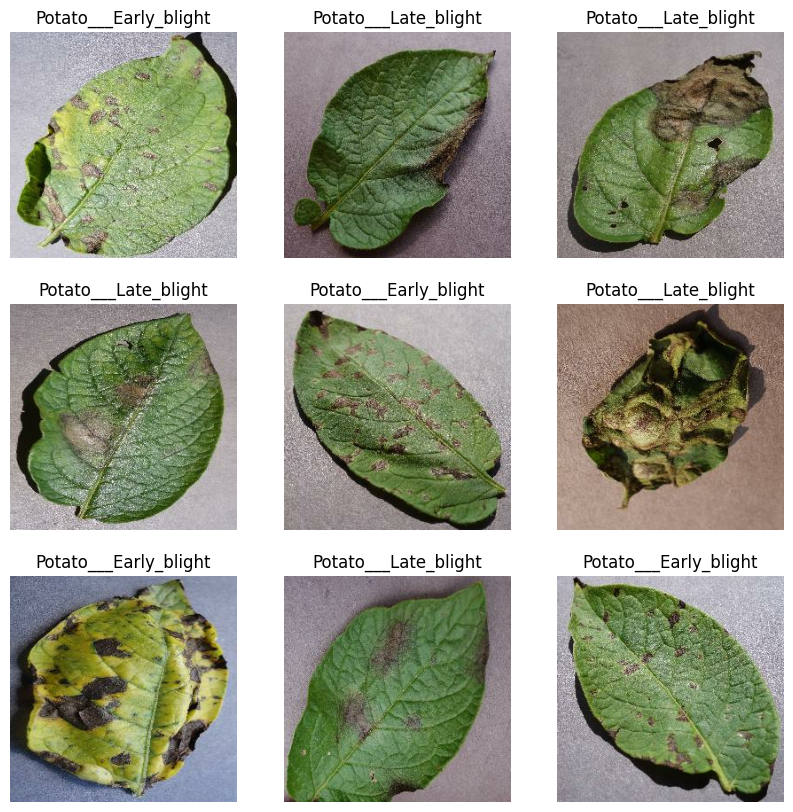

In [8]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    #print(image_batch[0].shape)
    #print(label_batch.numpy())

In [9]:
len(dataset)

68

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size= int(train_split* ds_size)
    val_size= int(val_split* ds_size)

    train_ds= ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

54

In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [16]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 15s 98ms/step - loss: 0.9294 - accuracy: 0.4595 - val_loss: 0.9045 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 3s 61ms/step - loss: 0.7467 - accuracy: 0.6308 - val_loss: 0.5989 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 3s 58ms/step - loss: 0.5080 - accuracy: 0.7818 - val_loss: 0.4004 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.3501 - accuracy: 0.8640 - val_loss: 0.2556 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 4s 70ms/step - loss: 0.3129 - accuracy: 0.8762 - val_loss: 0.2468 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 4s 66ms/step - loss: 0.2630 - accuracy: 0.9028 - val_loss: 0.1923 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2052 - accuracy: 0.9161 - val_loss: 0.2217 - val_accuracy: 0.9115
Epoch 8/50
5

In [20]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 26ms/step - loss: 0.0579 - accuracy: 0.9805


In [21]:
scores

[0.057857003062963486, 0.98046875]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['accuracy']

[0.45949074625968933,
 0.6307870149612427,
 0.7818287014961243,
 0.8640046119689941,
 0.8761574029922485,
 0.9027777910232544,
 0.9160879850387573,
 0.9328703880310059,
 0.9247685074806213,
 0.9525462985038757,
 0.9496527910232544,
 0.9427083134651184,
 0.9438657164573669,
 0.9565972089767456,
 0.9542824029922485,
 0.9537037014961243,
 0.9693287014961243,
 0.9733796119689941,
 0.9797453880310059,
 0.9751157164573669,
 0.9670138955116272,
 0.9403935074806213,
 0.9681712985038757,
 0.9872685074806213,
 0.9768518805503845,
 0.9895833134651184,
 0.9797453880310059,
 0.9826388955116272,
 0.9872685074806213,
 0.9814814925193787,
 0.9774305820465088,
 0.9895833134651184,
 0.984375,
 0.9837962985038757,
 0.9918981194496155,
 0.9855324029922485,
 0.9924768805503845,
 0.9791666865348816,
 0.9837962985038757,
 0.9797453880310059,
 0.9878472089767456,
 0.9872685074806213,
 0.9809027910232544,
 0.9878472089767456,
 0.9907407164573669,
 0.9930555820465088,
 0.9895833134651184,
 0.9947916865348816,
 

In [26]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

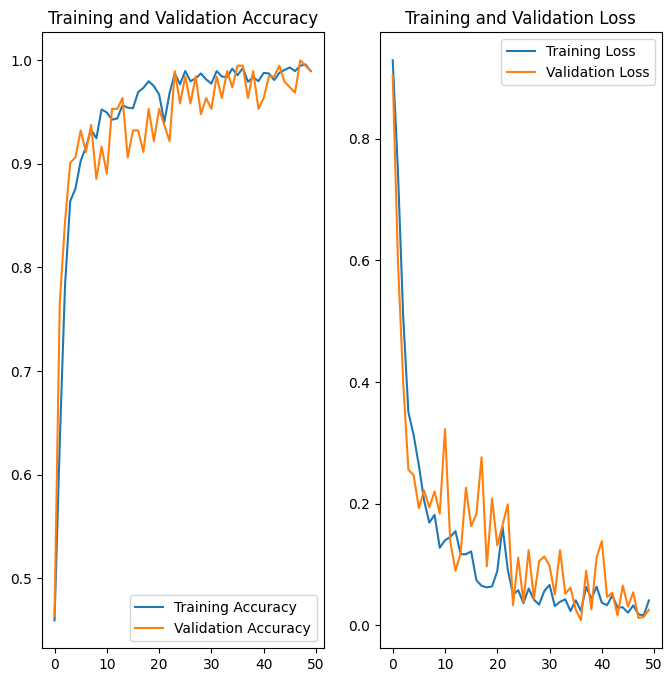

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

actual label:  Potato___healthy
1/1 [==============================] - 0s 143ms/step
predicted_label:  Potato___healthy


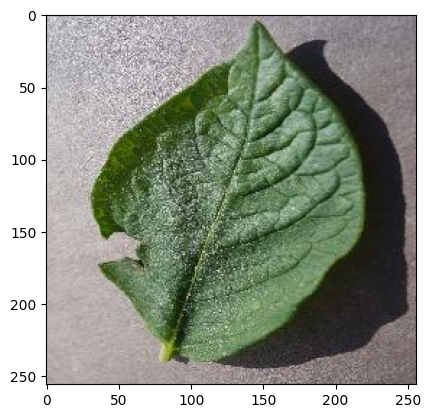

In [28]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0]

    plt.imshow(first_image)
    print("actual label: ",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print("predicted_label: ",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


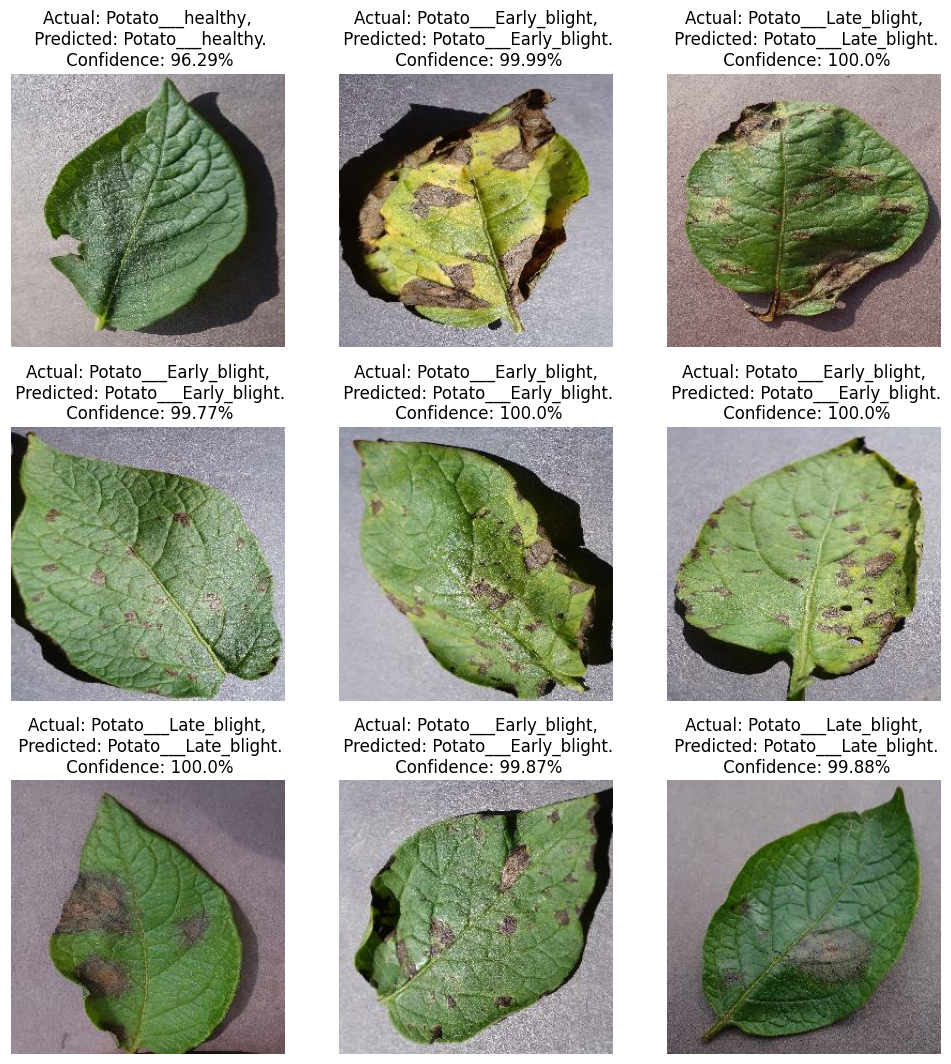

In [30]:

plt.figure(figsize=(12,13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [31]:
model_dir = "/content/drive/MyDrive/saved_models"
model_version = 1
model_export_path = f"{model_dir}/{model_version}"

tf.saved_model.save(
    model,
    export_dir=model_export_path,
)